### 데이터사이언스

In [1]:
import csv

from datetime import datetime
import matplotlib.pyplot as plt


In [2]:
import seaborn as sns


In [3]:
import pandas as pd

In [4]:
train_data = pd.read_csv('DS-main/datas/train.csv')
test_data = pd.read_csv('DS-main/datas/test.csv')

In [5]:


# 현재 날짜 계산 (Year, Month, Day 컬럼 사용)
train_data['Current Date'] = pd.to_datetime(train_data[['Year', 'Month', 'Day']])

# 새로운 변수들 생성

# 1. 신용 한도 변동성 (Credit Limit / Account Open Date)
train_data['Acct Open Date'] = pd.to_datetime(train_data['Acct Open Date'])
train_data['Account Duration'] = (train_data['Current Date'] - train_data['Acct Open Date']).dt.days
train_data['Credit Limit Volatility'] = train_data['Credit Limit'] / train_data['Account Duration']

# 2. 계좌 개설 후 소득 변동 (Per Capita Income / Account Open Date)
train_data['Income Change Since Account Open'] = train_data['Per Capita Income - Zipcode'] / train_data['Account Duration']

# 3. 사용자 신용 등급 그룹 (Credit Score / User)
train_data['Credit Score Group'] = pd.qcut(train_data['Credit Score'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# 4. 보안 칩 사용 여부 (Security Chip Used / Has Chip)
train_data['Chip Used'] = ((train_data['Has Chip'] == 'Yes') & (train_data['Whether Security Chip is Used'] == 'Yes')).astype(int)

# 5. 보안 갱신 여부 (PIN Last Changed / Security Used)
train_data['Security Updated'] = ((train_data['Year PIN last Changed'].notnull()) | (train_data['Whether Security Chip is Used'] == 'Yes')).astype(int)

# 6. 신용 점수 대비 신용 한도 비율 (Credit Score / Credit Limit)
train_data['Credit Score to Limit Ratio'] = train_data['Credit Score'] / train_data['Credit Limit']

# 7. 보안 업데이트 상태 (Has Chip / PIN Last Changed)
train_data['Security Status'] = ((train_data['Has Chip'] == 'Yes') & (train_data['Year PIN last Changed'].notnull())).astype(int)

# 8. 은퇴까지 남은 기간 (Retirement Age / Current Age)
train_data['Years to Retirement'] = train_data['Retirement Age'] - train_data['Current Age']

# 9. 부채 대비 소득 비율 (Yearly Income / Total Debt)
train_data['Debt to Income Ratio'] = train_data['Total Debt'] / train_data['Yearly Income']

# Merchandise Code와 Price (Amount) 간의 평균 관계 생성
merchandise_avg_price = train_data.groupby('Merchandise Code')['Amount'].mean().reset_index()
merchandise_avg_price.columns = ['Merchandise Code', 'Avg Price per Merchandise Code']

# train_data에 병합하여 새로운 변수 추가
train_data = pd.merge(train_data, merchandise_avg_price, on='Merchandise Code', how='left')


# Is Fraud 컬럼을 포함하여 저장
columns_to_save = [ 'User', 'Current Date', 'Credit Limit Volatility', 
    'Income Change Since Account Open', 'Credit Score Group', 'Chip Used', 'Security Updated', 
    'Credit Score to Limit Ratio', 'Security Status', 'Years to Retirement', 'Debt to Income Ratio', 
    'Avg Price per Merchandise Code', 'Is Fraud?'
]
# 새로운 데이터를 train_user.csv로 저장
train_data[columns_to_save].to_csv('train_user.csv', index=False)



In [6]:
# 데이터 불러오기
train_data = pd.read_csv('train_user.csv')

# 'Is Fraud' 컬럼에서 'No'를 0, 'Yes'를 1로 변환
train_data['Is Fraud?'] = train_data['Is Fraud?'].replace({'No': 0, 'Yes': 1})

# 변환된 데이터 확인
print(train_data['Is Fraud?'].head())

# 변환된 데이터를 다시 저장
train_data.to_csv('train_user.csv', index=False)


0    0
1    0
2    0
3    0
4    0
Name: Is Fraud?, dtype: int64


In [7]:
# 데이터 불러오기
train_data = pd.read_csv('train_user.csv')

# 특정 컬럼(Merchandise Code)의 고유한 값과 그 개수 출력
column_name = 'Chip Used'  # 원하는 컬럼명
unique_values = train_data[column_name].value_counts()

# 출력
print(f"'{column_name}' 컬럼의 데이터 종류와 개수:")
print(unique_values)


'Chip Used' 컬럼의 데이터 종류와 개수:
0    1644768
Name: Chip Used, dtype: int64


C:\Users\vml\AppData\Local\Temp\ipykernel_9064\3164138163.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_data.corr()
c:\Users\vml\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


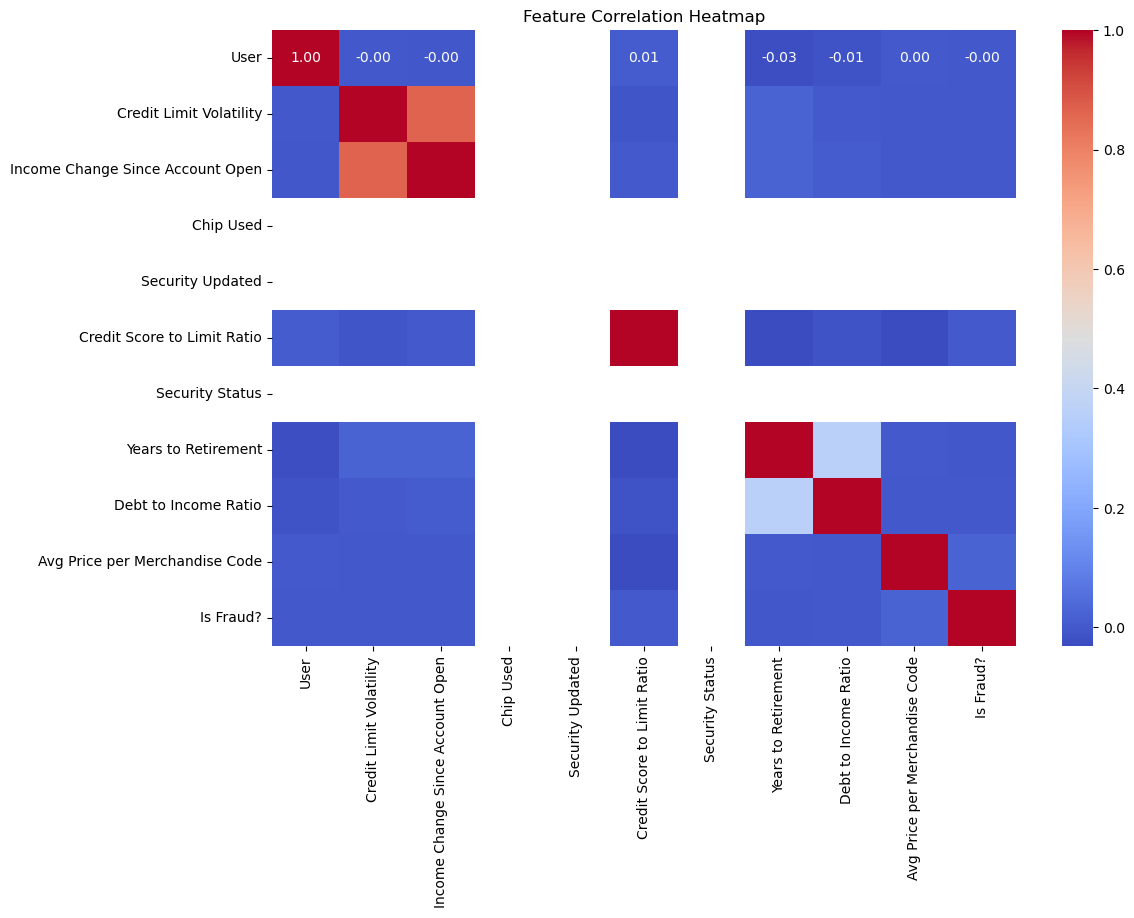

In [8]:
# 데이터 불러오기
train_data = pd.read_csv('train_user.csv')

# 각 컬럼 간의 상관관계 계산
corr_matrix = train_data.corr()

# 히트맵 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)

# 그래프 제목 추가
plt.title('Feature Correlation Heatmap')
plt.show()

In [9]:
from sklearn.decomposition import PCA


In [11]:


# 데이터 불러오기
train_data = pd.read_csv('train_user.csv')

# 'Is Fraud' 컬럼을 제외한 나머지 수치형 데이터를 추출
features = train_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Is Fraud'])

# NaN 값을 평균값으로 채우기
features = features.fillna(features.mean())

# PCA 모델 생성 및 적용 (2개의 주성분)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# PCA 결과를 데이터프레임에 추가
train_data['PCA1'] = pca_result[:, 0]
train_data['PCA2'] = pca_result[:, 1]

# PCA 결과 시각화 ('Is Fraud'에 따라 색을 구분)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Is Fraud', data=train_data, palette='coolwarm', s=60)
plt.title('PCA of Features with Is Fraud')
plt.show()


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values